# <center>Predicting Power Output for Combined Cycle Power Plant utilizing Linear Regression</center>

### Highlight  
This notebook makes an effort to understand the variations and applications of Linear regression to predict power output for a CCPP. 

## 1. Combined Cycle Power Plant Data Set

The dataset contains data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (AT), Exhaust Vacuum (V), Ambient Pressure (AP), and  Relative Humidity (RH) to predict the net hourly electrical energy output (PE) of the plant.

### (a) Download Data

Download the Combined Cycle Power Plant data 
from:
https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant

Package imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances
import warnings
warnings.filterwarnings('ignore')

print("========== Packages Imported ==========")

========== Packages Imported ==========


Get the Cycle Power Plant Data Set

In [2]:
# Importing Sheet1 from the CCPP excel file.

ccpp_data = pd.read_excel("../data/CCPP/Folds5x2_pp.xlsx", sheet_name="Sheet1")
ccpp_data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


### (b) Exploring the data

#### i. rows and columns

i. How many rows are in this data set? How many columns? What do the rows and columns represent?

In [3]:
# Information about the rows and columns of the dataset.

print("1) Number of rows in this dataset:", ccpp_data.shape[0])
print("2) Number of columns in this dataset:", ccpp_data.shape[1])

1) Number of rows in this dataset: 9568
2) Number of columns in this dataset: 5


============================================================================================================
<b>Information about the Dataset:</b>

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011).  
There are 4 feature columns and 1 label column present in the dataset.

<b>Features:</b>
1) Hourly average ambient variables Temperature (AT)
2) Exhaust Vacuum (V)
3) Ambient Pressure (AP)
4) Relative Humidity (RH)

<b>Label:</b>
1) Net hourly electrical energy output (PE)

============================================================================================================

#### ii. pairwise scatterplots of all the varianbles

ii. Make pairwise scatterplots of all the varianbles in the data set including the predictors (independent variables) with the dependent variable. Describe your findings.

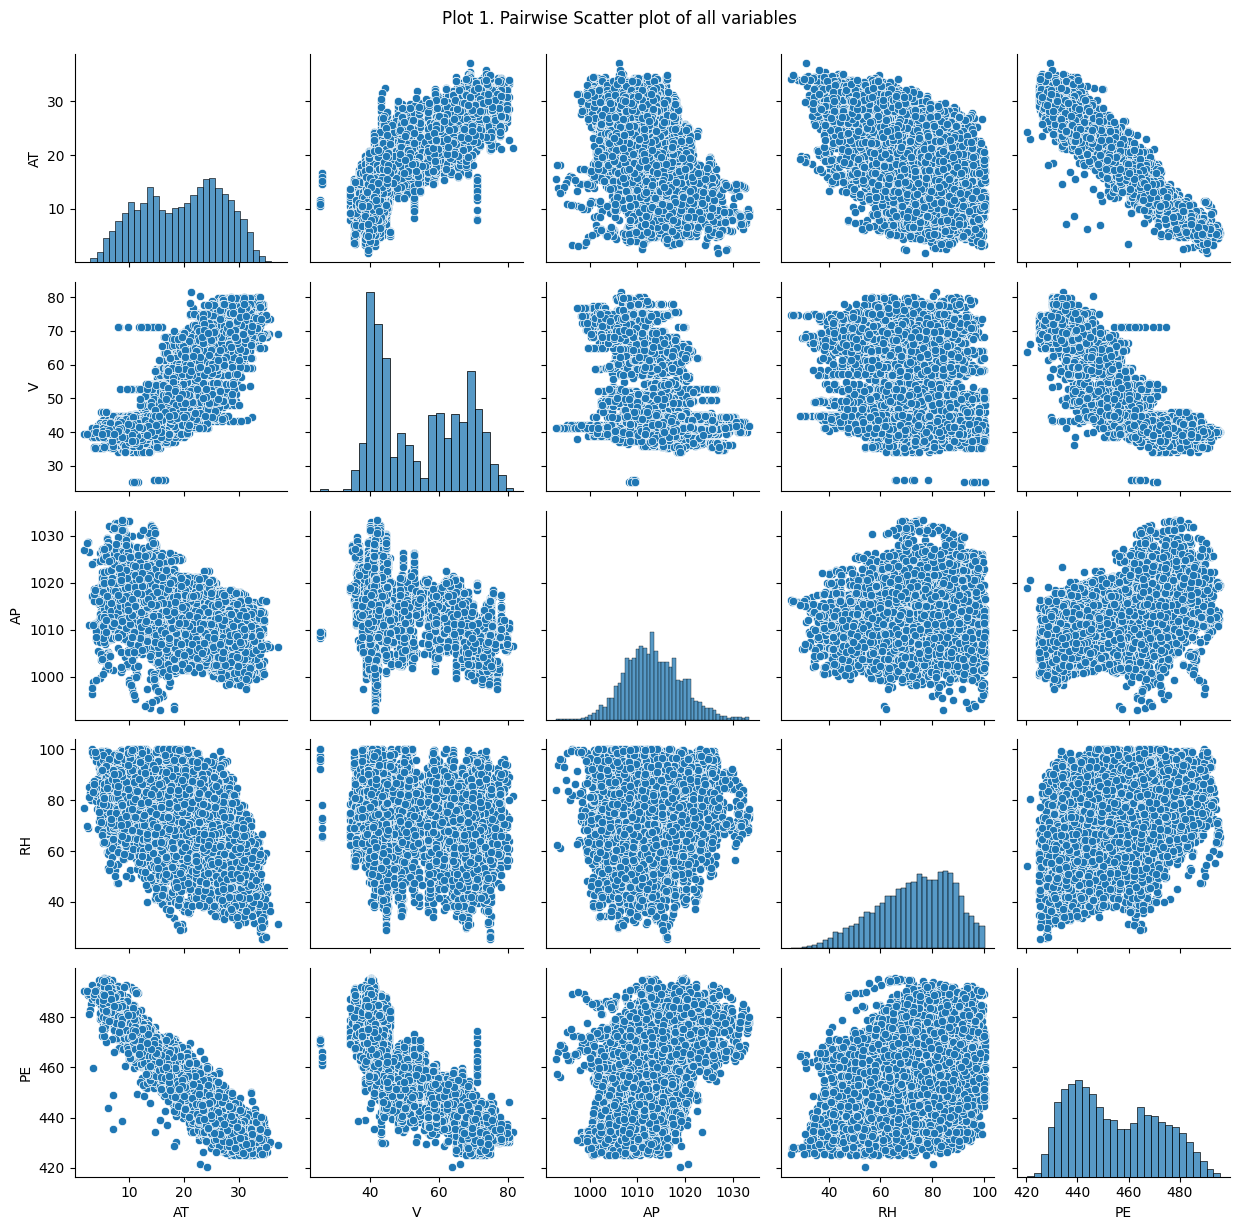

In [4]:
# Scatterplot for all the variables.

sns.pairplot(data=ccpp_data)
plt.suptitle("Plot 1. Pairwise Scatter plot of all variables\n")
plt.tight_layout()
plt.show()

<b>Findings and observations:</b>

1) AT and V are positively correlated
2) AT and PE are negatively correlated
3) V and PE are negatively correlated
4) AP has a distribution which resembles almost like a normal distribution
5) V and AT are definitely good predictors of PE
6) It seems that V has many outliers
<br>

#### iii. mean, the median, range, first and third quartiles, and interquartile ranges

iii. What are the mean, the median, range, first and third quartiles, and interquartile ranges of each of the variables in the dataset? Summarize them 
in a table.

In [5]:
# Creating empty lists to store descriptive statistics data for all columns.
means = []
medians = []
ranges = []
firstqtls = []
thirdqtls = []
interqtls = []

# Looping through all columns to capture and store their statistical details in the lists.
for col in ccpp_data.columns:
    means.append(np.mean(ccpp_data[col]))
    medians.append(np.median(ccpp_data[col]))
    ranges.append(np.max(ccpp_data[col]) - np.min(ccpp_data[col]))
    firstqtls.append(np.quantile(ccpp_data[col], 0.25))
    thirdqtls.append(np.quantile(ccpp_data[col], 0.75))
    interqtls.append(np.quantile(ccpp_data[col], 0.75) - np.quantile(ccpp_data[col], 0.25))

# Creating Summary table using Dataframe.
summary_df = pd.DataFrame({
    "Column": ccpp_data.columns,
    "Mean": means,
    "Median": medians,
    "Range": ranges,
    "First_Quartile": firstqtls,
    "Third_Quartile": thirdqtls,
    "Interquartile_Range": interqtls})
summary_df.set_index("Column", inplace=True)
summary_df.head()

,Mean,Median,Range,First_Quartile,Third_Quartile,Interquartile_Range
Column,,,,,,
AT,19.651231,20.345,35.30,13.5100,25.72,12.2100
V,54.305804,52.080,56.20,41.7400,66.54,24.8000
AP,1013.259078,1012.940,40.41,1009.1000,1017.26,8.1600
RH,73.308978,74.975,74.60,63.3275,84.83,21.5025
PE,454.365009,451.550,75.50,439.7500,468.43,28.6800


### (c) Simple Linear Regression

For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks?

In [6]:
# Please note that, I have used the statsmodel package to fit the linear regression model as it was suggested by professor in previous lectures.
# Also, since statsmodel package is something which I had never used before, I tried my best to study and research about it before implementing it.
# The citations for the same have been mentioned towards the end of this notebook. Also, I have made an effort to explain my learnings while applying it.
# Also, unlike my previously submitted HW1, this time I have created functions for processes so that I do not have to code the same things again.
# Hope it also helps the instructors in their review!

# Function to fit the model.
def sim_lin_reg_model(y, x_constant):
    sim_reg_model = sm.OLS(y, x_constant).fit() 
    print(sim_reg_model.summary())
    return sim_reg_model

# Function to identify outliers in the data points. 
# I have used cooks distance to identify outliers as it was one of the suggestions on piazza.
# I learned that Cook’s Distance is a measure of a data point's influence on linear regression.
# And that the data points with large influence might be outliers.
def outlier_detection(model):
    # As a general rule of thumb, it is said that (Cooks_distance > 4/number_of_data_points) is a good threshold-
    # for determining highly influential points as outliers. Hence, I have applied it here to find outliers.
    influence = model.get_influence()
    cooks_dist = influence.cooks_distance
    outliers_indexes = np.where(cooks_dist[0] > (4 / ccpp_data.shape[0]))
    if len(outliers_indexes[0]) == 0:
        print("\n\n========== No Outliers Present ==========\n\n")
    else:
        print("\n\n================================== Outliers ==================================")
        print("There are {} outliers present in data for this column.\n\n".format(len(outliers_indexes[0])))
    return outliers_indexes

# Function to plot the data points, outliers, and regression line for a specific column.
def collective_plots(x, y, outliers_indexes, model, x_constant, plot_num, col_name):
    #fig, ax = plt.subplots(figsize=(10, 6))
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=x, y=y, marker="o", label="Data points", alpha=0.6)
    sns.scatterplot(x=x[outliers_indexes], y=y[outliers_indexes], marker="D", label="Outliers", alpha=0.6)
    
    # The regression line will help us with the statistical significance of predictors.
    plt.plot(x, model.predict(x_constant), color="green", label="Regression Line", alpha=0.8)
    
    plt.title("Plot {0}. Simple Linear Regression with {1}".format(plot_num, col_name))
    plt.xlabel(col_name)
    plt.ylabel("PE") 
    
    plt.legend()
    plt.show()

# Empty dictionary to store model parameters (or coefficiant estimates) for all columns.
sep_col_params = {}

# Function to fit and summarize the model on data.
def model_fit_summarize_plot(plot_num, col_name):
    print("\n=============================== Model Summary ================================")
    print("Simple Linear Regression with column = {}\n\n".format(col_name))
    # Only taking predictors into consideration.
    if (col_name in ["AT", "V", "AP", "RH"]):
        # The x and y should be array-like, as mentioned in the statsmodel documentation.
        y = ccpp_data["PE"].to_numpy()
        x = ccpp_data[col_name].to_numpy()
        
        # It turns out that in statsmodel, we need to add our own constant, or else the regression line will be forced to go from origin.
        # I have kept prepend=False as this will help later in question 1(e). Mainly while accessing the coefficient estimates.
        x_constant = sm.add_constant(x, prepend=False)

        # Calling the model fitting function.
        model = sim_lin_reg_model(y, x_constant)

        # Calling the outlier detection function.
        outliers_indexes = outlier_detection(model)

        # Capturing the model parameters (or coefficiant estimates) for the current column.
        sep_col_params[col_name] = model.params

        # Calling the plots function.
        collective_plots(x, y, outliers_indexes, model, x_constant, plot_num, col_name)


=============================== Model Summary ================================
Simple Linear Regression with column = AT


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        01:39:25   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------

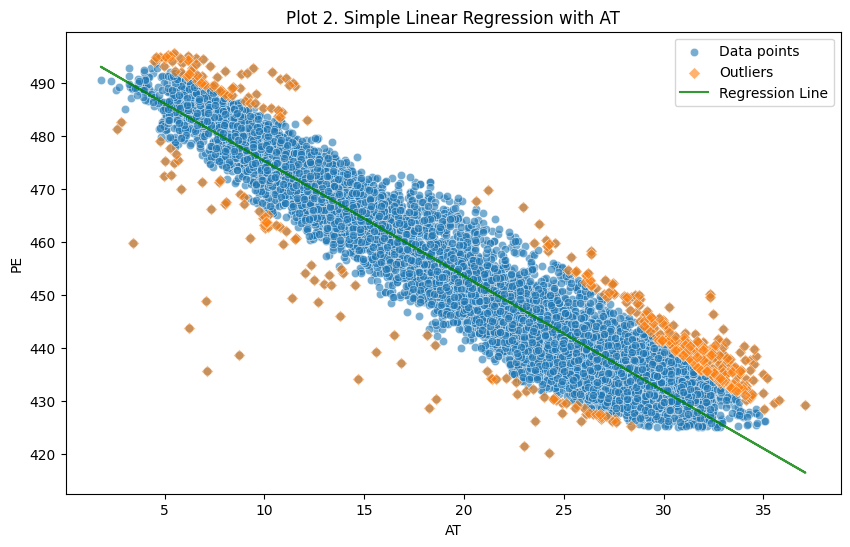


=============================== Model Summary ================================
Simple Linear Regression with column = V


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        01:39:25   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

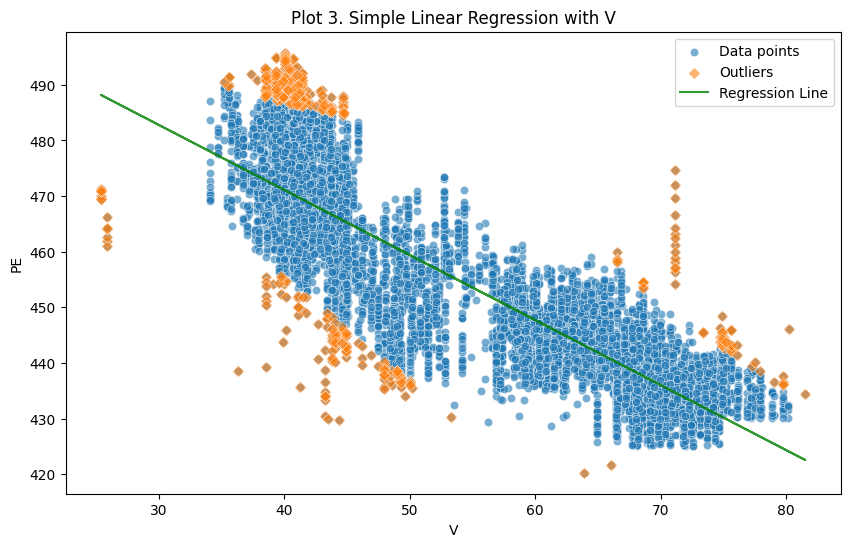


=============================== Model Summary ================================
Simple Linear Regression with column = AP


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        01:39:26   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------

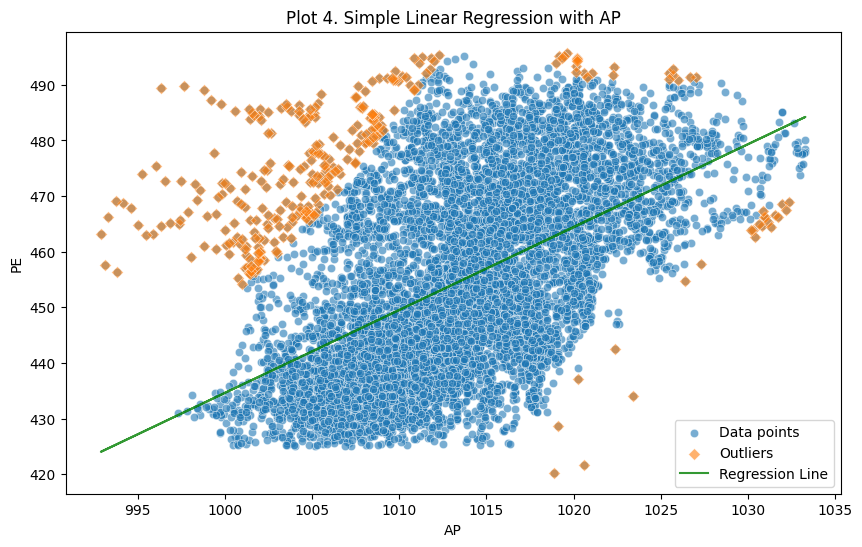


=============================== Model Summary ================================
Simple Linear Regression with column = RH


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        01:39:27   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------

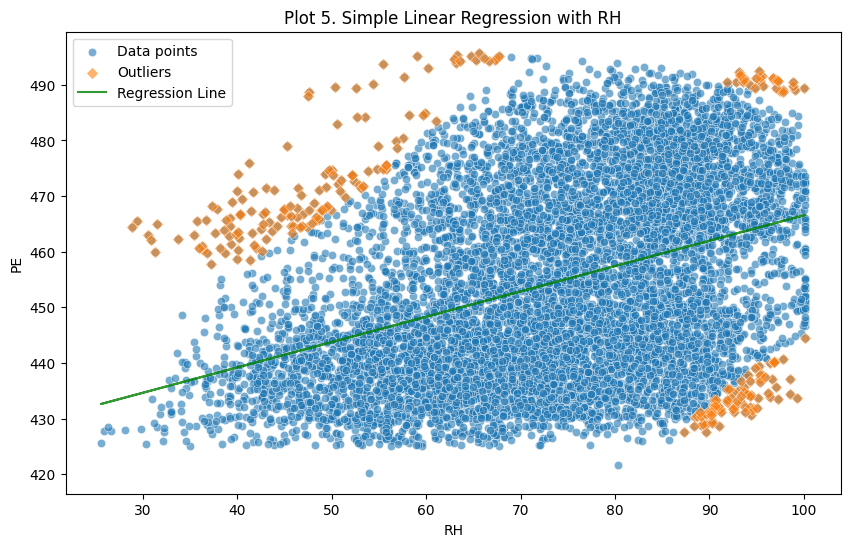

In [7]:
# Calling the above functions for all predictor columns one-by-one.
for i in range(0,4):
    model_fit_summarize_plot(i+2, ccpp_data.columns[i])

### (d) Multiple Regression

Fit a multiple regression model to predict the response using all of the predictors.
Describe your results. For which predictors can we reject the null hypothesis
H0 : βj = 0?

In [8]:
x_all_predictors = ccpp_data[ccpp_data.columns[0:4]]

# Keeping prepend=False will push the constant coefficient (or the intercept coefficent) to the end of the param array.
# After few iterations, I figured that this arrangment will help in accessing the coefficients for question 1(e).
x_all_predictors = sm.add_constant(x_all_predictors.to_numpy(), prepend=False)

mul_lin_reg_model = sm.OLS(ccpp_data["PE"].to_numpy(), x_all_predictors).fit()
print("\n========================== Multiple Linear Regression ========================\n\n", mul_lin_reg_model.summary())


========================== Multiple Linear Regression ========================

                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        01:39:28   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

<b>Describing results:</b>  
The null hypothesis (H0 : βj = 0) can be rejected for all the 4 predictors since the p-value for all of them is 0.  
This indicates that all the 4 features are indeed good predictors of the label column (PE).

### (e) 1c Compare to 1d

How do your results from 1c compare to your results from 1d? Create a plot
displaying the univariate regression coefficients from 1c on the x-axis, and the
multiple regression coefficients from 1d on the y-axis. That is, each predictor is
displayed as a single point in the plot. Its coefficient in a simple linear regression
model is shown on the x-axis, and its coefficient estimate in the multiple linear
regression model is shown on the y-axis.

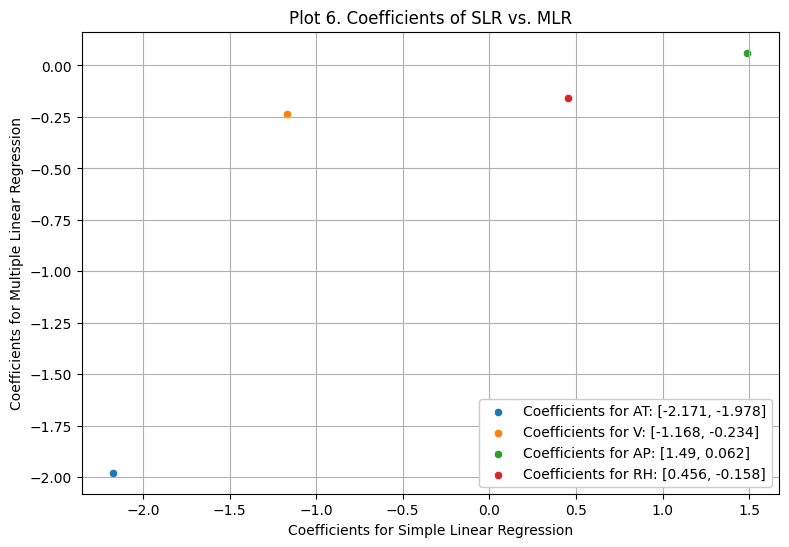

In [9]:
# Plotting the coefficients of simple linear regression on x-axis and coefficients of multiple linear regression on y-axis.
plt.figure(figsize=(9,6))

# Loop to iterate through all the predictor columns and parameter coefficients.
for i in range(0,4):
    sim_coeff = round(sep_col_params[ccpp_data.columns[i]][0], 3)
    mul_coeff = round(mul_lin_reg_model.params[i], 3)
    legend = "Coefficients for {0}: [{1}, {2}]".format(ccpp_data.columns[i], sim_coeff, mul_coeff)
    sns.scatterplot(x=[sim_coeff], y=[mul_coeff], label=legend)

# Labels and title.
plt.title("Plot 6. Coefficients of SLR vs. MLR")
plt.xlabel("Coefficients for Simple Linear Regression")
plt.ylabel("Coefficients for Multiple Linear Regression")

# Finishing touches.
plt.legend(framealpha=1)
plt.grid(True)
plt.show()

<b>Explanation of plot:</b>  
- Every feature has more weight when used alone rather than together.
- RH influence PE negatively when used along with other predictors 

### (f) Nonlinear Association

Is there evidence of nonlinear association between any of the predictors and the response? To answer this question, for each predictor X, fit a model of the form Y = β0 + β1X + β2X^2 + β3X^3 + E

In [10]:
# To showcase this evidence, I have again used the statsmodel package to fit the model.
# Also, I used the PolynomialFeatures package to deal with the 3rd degree parametric model requirement.

# Function to create a 3rd degree polynomial model. Because (Y = β0 + β1X + β2X^2 + β3X^3 + E) is a 3rd degree polynomial.
def polynomial_3d(col_name):
    poly = PolynomialFeatures(3)
    x_train_poly = poly.fit_transform(ccpp_data[col_name].to_numpy().reshape(-1, 1))
    x_train_poly = sm.add_constant(x_train_poly)
    model = sm.OLS(ccpp_data["PE"].to_numpy(), x_train_poly).fit()
    print("\n\n======================== Polynomial Regression for {} ========================\n".format(col_name))
    print(model.summary())

# Looping through all the predictor columns and calling the polynomial function.
for i in range(0, 4):
    polynomial_3d(ccpp_data.columns[i])



======================== Polynomial Regression for AT ========================

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        01:39:28   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

<b>Results:</b>  
1) We can reject the null hypothesis for features AP, AT, and RH, as their p-values are 0.
2) This means that there is indeed a non-linear association between these 3 features and the label (PE).
3) For feature V, the p-value for x^2 is significantly greater considering 5% significance, so we cannot reject the null hypothesis.
4) Hence, feature V may not have a non-linear quadratic association with the label (PE).

### (g) Interactions of Predictors

Is there evidence of association of interactions of predictors with the response? To
answer this question, run a full linear regression model with all pairwise interaction
terms and state whether any interaction terms are statistically significant.

In [11]:
# When we are dealing with interaction terms, we need to mention the interaction formula in the model function.
# This formula includes all the pairwise interaction terms. As there are 4 variables, we can do 4C2 which gives us 6 pairwise combinations.
interaction_formula = "PE ~ AT + V + AP + RH + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH"

interaction_model = smf.ols(formula=interaction_formula, data=ccpp_data).fit()
print("\n========================== Interaction Model Summary =========================\n")
print(interaction_model.summary())


========================== Interaction Model Summary =========================

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        01:39:29   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

<b>Results:</b>  
- As a general rule, if p-values are less than 0.05 (5% significance), we reject the null hypothesis, and we say that the feature is significant.
- However, the 0.05 value is not a firm or absolute measure. Hence, we might get different set of significant features if this value is changed.
- For the sake of this question, I have considered the 5% significance (0.05) to check the p-values and hence conclude on the significant features.

<b>Considering 5% significance:</b>  
1) Features V, AP, RH, AT:V, AT:RH, V:AP, AP:RH are statistically significant as for them, p-values < 0.05
2) Features AT, AT:AP, V:RH are not statistically significant as for them, p-values > 0.05


### (h) Improvement

Can you improve your model using possible interaction terms or nonlinear associations between the predictors and response? Train the regression model on a
randomly selected 70% subset of the data with all predictors. Also, run a regression model involving all possible interaction terms and quadratic nonlinearities,
and remove insignificant variables using p-values (be careful about interaction
terms). Test both models on the remaining points and report your train and test
MSEs.

In [12]:
# Using the train_test_split function from sklearn to randomly split the dataset and keep 70% for training. 
X = ccpp_data.drop('PE', axis=1)
Y = ccpp_data['PE']
x_train_70, x_test_30, y_train_70, y_test_30 = train_test_split(X, Y, train_size=0.7, random_state=1)

# Printing to verify the counts.
print("Shape of training set:", x_train_70.shape)
print("Shape of training label:", y_train_70.shape)
print("Shape of testing set:", x_test_30.shape)
print("Shape of testing label:", y_test_30.shape)

# However, to fit the data into statsmodel package with formula, we need to provide the training dataset with labels.
# Hence, concatinating x_train_70 and y_train_70 to create a training set with labels.
train_70 = pd.concat([x_train_70, y_train_70], axis=1)

# Printing to verify the counts.
print("Shape of training data for fitting:", train_70.shape, "\n")

Shape of training set: (6697, 4)
Shape of training label: (6697,)
Shape of testing set: (2871, 4)
Shape of testing label: (2871,)
Shape of training data for fitting: (6697, 5) 



In [13]:
# Creating empty lists to store cumulative models' data.
model_dcp_list =[]
train_mse_list = []
test_mse_list = []

# Function to train model and store prediction results into summary.
def model_training(model_description, formula):
    model = smf.ols(formula, train_70).fit()
    print("\n>>> Results of Model trained for condition: {}\n".format(model_description))
    print(model.summary())

    # Predicting for training and testing set.
    y_train_pred = model.predict(x_train_70)
    y_test_pred = model.predict(x_test_30)

    # Capturing training and testing MSE.
    train_mse = mean_squared_error(y_train_70, y_train_pred)
    test_mse = mean_squared_error(y_test_30, y_test_pred)

    # Appending MSEs to the lists.
    if model_description not in model_dcp_list:
        model_dcp_list.append(model_description)
        train_mse_list.append(round(train_mse, 3))
        test_mse_list.append(round(test_mse, 3))

    # Returning the cumulative summary table.
    summary_df = pd.DataFrame({"Model_description":model_dcp_list, "Train_MSE":train_mse_list, "Test_MSE":test_mse_list})
    summary_df.set_index("Model_description", inplace=True)
    print("\n>>> Cumulative Summary Table for Training and Testing MSEs:\n")
    return summary_df

In [14]:
# Training the model with all predictors.
formula_1 = "PE ~ AT + V + AP + RH"
model_description_1 = "Considering all predictors collectively"
model_training(model_description_1, formula_1)


>>> Results of Model trained for condition: Considering all predictors collectively

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.167e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        01:39:29   Log-Likelihood:                -19660.
No. Observations:                6697   AIC:                         3.933e+04
Df Residuals:                    6692   BIC:                         3.936e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

,Train_MSE,Test_MSE
Model_description,,
Considering all predictors collectively,20.766,20.777


In [15]:
# Training the model with all predictors, their quadratic powers, and the interaction terms.
formula_2 = "PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(V,2) + np.power(AP,2) + np.power(RH,2) + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH"
model_description_2 = "Considering all, quadratic & interaction terms"
model_training(model_description_2, formula_2)


>>> Results of Model trained for condition: Considering all, quadratic & interaction terms

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     7181.
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        01:39:29   Log-Likelihood:                -19192.
No. Observations:                6697   AIC:                         3.841e+04
Df Residuals:                    6682   BIC:                         3.852e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

,Train_MSE,Test_MSE
Model_description,,
Considering all predictors collectively,20.766,20.777
"Considering all, quadratic & interaction terms",18.060,18.217


<b>Considering 5% significance:</b>  
- As the p-values for V, V^2, AT:AP, V:AP, V:RH are greater than 0.05, we cannot reject the null hypothesis.
- Hence, V, V^2, AT:AP, V:AP, V:RH are not statistically significant.

However, even though V is statistically insignificant, we should'nt remove it from equation, as it is a basic predictor, and we still have AT:V term.   
Hence, we will remove the insignificant features, <b>V^2, AT:AP, V:AP, V:RH</b> for our next training.

In [16]:
# Training the model after removing statistically insignificant terms.
formula_3 = "PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(AP,2) + np.power(RH,2) + AT*V + AT*RH + AP*RH"
model_description_3 = "Removing statistically insignificant terms"
lr_summary_df = model_training(model_description_3, formula_3)
lr_summary_df


>>> Results of Model trained for condition: Removing statistically insignificant terms

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 1.004e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        01:39:30   Log-Likelihood:                -19198.
No. Observations:                6697   AIC:                         3.842e+04
Df Residuals:                    6686   BIC:                         3.849e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

,Train_MSE,Test_MSE
Model_description,,
Considering all predictors collectively,20.766,20.777
"Considering all, quadratic & interaction terms",18.060,18.217
Removing statistically insignificant terms,18.093,18.264


### (i) KNN

Perform k-nearest neighbor regression for this dataset using both normalized
and raw features. Find the value of k ∈ {1, 2, . . . , 100} that gives you the
best fit. Plot the train and test errors in terms of 1/k.

In [17]:
# Creating empty lists to store cumulative summary results.
feature_state_list = []
k_star_list = []
min_train_MSE_list = []
min_test_MSE_list = []

In [18]:
# Function to fit the KNN regression model.
def knn_model(feature_state):
    # Condition to normalize the features.
    if feature_state.lower() == "normalized":
        mms = MinMaxScaler()
        x_train_knn = mms.fit_transform(x_train_70)
        x_test_knn = mms.fit_transform(x_test_30) 
    else:
        x_train_knn = x_train_70
        x_test_knn = x_test_30

    # Defining empty lists to store error values.
    k_inv = []
    train_error = []
    test_error = []

    # Defining sample values for k from 1 to 100.
    k = [x for x in range(1, 101)]

    # Creating a loop to fit the model with each value of k.
    for k_i in k:
        knn_e = KNeighborsRegressor(n_neighbors=k_i)
        ## Please note that I have used x_train.values and y_train.values here instead of x_train, y_train as I faced an error with the latter. 
        ## After researching the error, probably something to do with the scikit-learn version that I am using.
        knn_e.fit(x_train_knn, y_train_70)
 
        # Predicting values for training and testing data.
        y_pred_train = knn_e.predict(x_train_knn)
        y_pred_test = knn_e.predict(x_test_knn)

        # Calculating training and testing errors using MSE score and storing each of them in the lists.
        train_error.append(mean_squared_error(y_train_70, y_pred_train))
        test_error.append(mean_squared_error(y_test_30, y_pred_test))
        k_inv.append(1/k_i)
    
    # The best k is the one that has the lowest testing error, i.e., value at the index of list 'k', at which the test_error is minimum.
    feature_state_list.append(feature_state)
    k_star_list.append(k[test_error.index(min(test_error))])
    min_train_MSE_list.append(train_error[test_error.index(min(test_error))])
    min_test_MSE_list.append(min(test_error))

    # Creating dataframe to store cumulative best-k values and errors.
    knn_summary_df = pd.DataFrame({"Feature_state": feature_state_list, 
                                   "Best_k": k_star_list, 
                                   "Train_MSE": min_train_MSE_list,
                                   "Test_MSE": min_test_MSE_list})
    knn_summary_df.set_index("Feature_state", inplace=True)
    return(knn_summary_df, k_inv, train_error, test_error)  

def plot_errors(plot_num, k_inv, train_error, test_error):
    # Generating plots.
    plt.figure(figsize=(8,5))
    plt.plot(k_inv, train_error, label="Training MSE")
    plt.plot(k_inv, test_error, label="Testing MSE")
    
    # Labels and title.
    plt.xlabel("1/k")
    plt.ylabel("Mean Squared Error")
    plt.title("Plot {}. Error Rate vs. k".format(plot_num))

    # Finishing touches.
    plt.legend(framealpha=1)
    plt.grid(True)
    plt.show()
    

In [19]:
knn_summary_df_raw, k_inv_raw, train_error_raw, test_error_raw = knn_model("Raw")
knn_summary_df_raw

,Best_k,Train_MSE,Test_MSE
Feature_state,,,
Raw,5,10.552961,15.704821


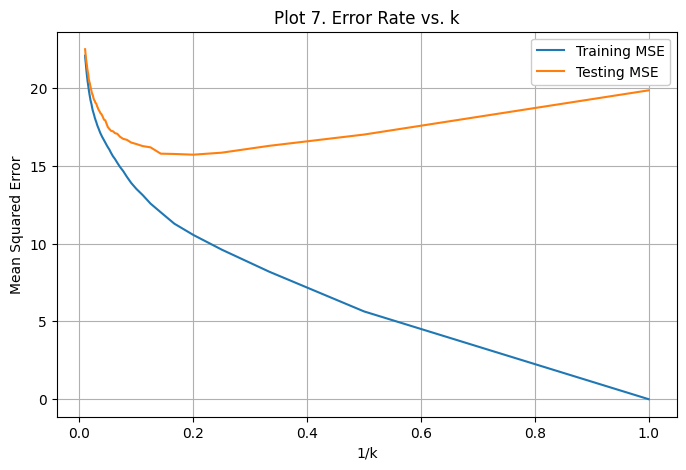

In [20]:
plot_errors(7, k_inv_raw, train_error_raw, test_error_raw)

In [21]:
knn_summary_df_norm, k_inv_norm, train_error_norm, test_error_norm = knn_model("Normalized")
knn_summary_df_norm

,Best_k,Train_MSE,Test_MSE
Feature_state,,,
Raw,5,10.552961,15.704821
Normalized,7,11.011892,14.910645


The Normalized featues provide a better model fit.

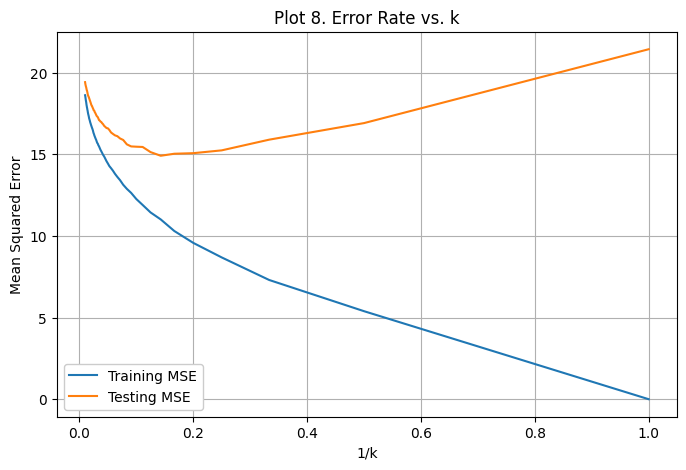

In [22]:
plot_errors(8, k_inv_norm, train_error_norm, test_error_norm)

### (j ) Compare KNN and Linear

Compare the results of KNN Regression with the linear regression model that has
the smallest test error and provide your analysis.

In [23]:
# For the sake of comparison, I have created a dataframe with all the previous errors.
final_summary = pd.DataFrame({
    "Feature_description": list(lr_summary_df.index) + list(knn_summary_df_norm.index),
    "Train_MSE": list(lr_summary_df["Train_MSE"]) + list(knn_summary_df_norm["Train_MSE"]),
    "Test_MSE": list(lr_summary_df["Test_MSE"]) + list(knn_summary_df_norm["Test_MSE"])}).set_index("Feature_description")
final_summary

,Train_MSE,Test_MSE
Feature_description,,
Considering all predictors collectively,20.766000,20.777000
"Considering all, quadratic & interaction terms",18.060000,18.217000
Removing statistically insignificant terms,18.093000,18.264000
Raw,10.552961,15.704821
Normalized,11.011892,14.910645


<b>Result Analysis:</b>  
- KNN model performs better than the Linear Regression model.
- This tells us that infact the nature of data might not be linear.
- That is why the Linear Regression model did not capture the data as good as the KNN model.

  
<b>References & Citations:</b>  
1) https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
2) https://www.statsmodels.org/stable/gettingstarted.html
3) https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html
4) https://www.statsmodels.org/dev/generated/statsmodels.tools.tools.add_constant.html
5) https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a
6) https://developer.nvidia.com/blog/a-comprehensive-guide-to-interaction-terms-in-linear-regression/#:~:text=An%20important%2C%20and%20often%20forgotten,value%20of%20another%20independent%20variable.
7) https://stackoverflow.com/questions/67940110/difference-between-normalizer-and-minmaxscaler#:~:text=MinMaxScaler%20is%20applied%20column%2Dwise%2C%20Normalizer%20is%20applied%20row%2D,a%20row%2Dbased%20normalization%20technique.
8) https://matplotlib.org/3.1.3/gallery/pyplots/pyplot_scales.html
9) https://www.tutorialspoint.com/finding-euclidean-distance-using-scikit-learn-in-python
10) https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html
11) https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
12) https://www.scikit-yb.org/en/latest/api/regressor/influence.html#:~:text=Because%20of%20this%2C%20Cook's%20Distance,that%20is%20above%20that%20threshold.
13) https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
14) https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html